# Import Dependecies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

In [2]:
from IPython.display import clear_output as cls
!pip install kaggle
cls()

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# celeb dataset
!kaggle datasets download -d quadeer15sh/celeba-face-recognition-triplets
!unzip /content/celeba-face-recognition-triplets.zip

# lfw dataset
!kaggle datasets download -d quadeer15sh/lfw-face-recognition
!unzip /content/celeba-face-recognition-triplets.zip
cls()

In [4]:
import os
import re
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, Layer, Lambda, BatchNormalization
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, MobileNetV2, EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

from sklearn.metrics.pairwise import euclidean_distances as L2

# Data

In [5]:
data = pd.read_csv("/content/CelebA FR Triplets/CelebA FR Triplets/triplets.csv")
data = data.sample(frac=1).reset_index(drop=True)
data

anchor   id1         pos   id2         neg   id3
0      122449.jpg  9855  011794.jpg  9855  107818.jpg  2176
1      150623.jpg  5179  010159.jpg  5179  092601.jpg   230
2      049206.jpg  1578  030288.jpg  1578  129445.jpg  3963
3      115295.jpg   825  103543.jpg   825  131954.jpg   974
4      149325.jpg  3418  037130.jpg  3418  071146.jpg  5359
...           ...   ...         ...   ...         ...   ...
16327  113041.jpg  1015  097394.jpg  1015  081666.jpg  5782
16328  087740.jpg  5505  034396.jpg  5505  014361.jpg  5884
16329  190043.jpg  6723  196011.jpg  6723  176446.jpg  4592
16330  002456.jpg  8616  086217.jpg  8616  090714.jpg   255
16331  155649.jpg  6849  015548.jpg  6849  091616.jpg  2031

[16332 rows x 6 columns]

In [6]:
train = data.head(14332)
test = data.tail(2000)

In [7]:
image_path = '/content/CelebA FR Triplets/CelebA FR Triplets/images'

# My Model

## Embedding Layer

In [8]:
def make_embedding():
  inp = Input(shape=(100,100,3), name='input_image')
  # First block
  c1 = Conv2D(32, (10,10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

  # Second block
  c2 = Conv2D(64, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

  # Third block
  c3 = Conv2D(64, (4,4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

  # Final embedding block
  c4 = Conv2D(128, (4,4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)
  return Model(inputs=[inp], outputs=[d1], name='embedding')

embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 32)          │           9,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 64)          │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 64)          │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      18,878,464 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,185,312 (73.19 MB)

 Trainable params: 19,185,312 (73.19 MB)

 Non-trainable params: 0 (0.00 B)

## Distance Layer

In [9]:
# # Siamese L1 Distance class
# class L1Dist(Layer):

#     # Init method - inheritance
#     def __init__(self, **kwargs):
#         super().__init__()

#     # Magic happens here - similarity calculation
#     def call(self, input_embedding, validation_embedding):
#         return tf.math.abs(input_embedding - validation_embedding)

class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        # Ensure inputs are tensors and not lists
        input_embedding = input_embedding[0]  # Extract tensor from list
        validation_embedding = validation_embedding[0]  # Extract tensor from list
        return tf.math.abs(input_embedding - validation_embedding)

l1 = L1Dist()

## Siamese Model

In [10]:
image_input1 = Input(shape=(100,100,3),name='Image1')
image_input2 = Input(shape=(100,100,3),name='Image2')
image_input3 = Input(shape=(100,100,3),name='Image3')

anchor = embedding(image_input1)
positive = embedding(image_input2)
negative = embedding(image_input3)

siamese_network = Model(inputs=[image_input1,image_input2,image_input3], outputs=[anchor,positive,negative])
siamese_network.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Image1 (InputLayer)       │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Image2 (InputLayer)       │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Image3 (InputLayer)       │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     19,185,312 │ Image1[0][0],          │
│                           │                        │                │ Image2[0][0],          │
│                           │                        │                │ Image3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 19,185,312 (73.19 MB)

 Trainable params: 19,185,312 (73.19 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# def make_siamese_model():
#   # Anchor image input in the network
#   input_image = Input(name='input_img', shape=(100,100,3))
#   # Validation image in the network
#   validation_image = Input(name='validation_img', shape=(100,100,3))
#   # Combine siamese distance components
#   siamese_layer = L1Dist()
#   siamese_layer._name = 'distance'
#   distances = siamese_layer(embedding(input_image), embedding(validation_image))
#   # Classification layer
#   classifier = Dense(1, activation='sigmoid')(distances)

#   return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

# siamese_model = make_siamese_model()
# siamese_model.summary()

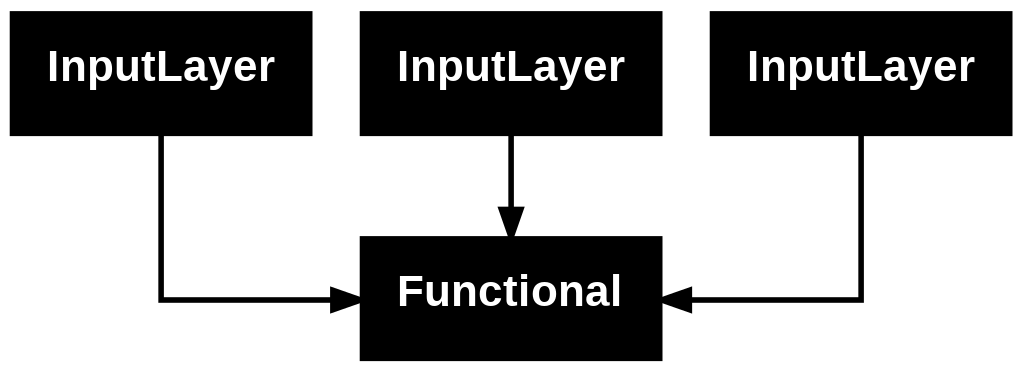

In [12]:
tf.keras.utils.plot_model(siamese_network)

# Triplet Gen

In [31]:
batch_size = 32
datagen = ImageDataGenerator(rescale=1/255.)

class TripleGenerator(tf.keras.utils.Sequence):

    def __init__(self, gen1, gen2, gen3):

        self.gen1 = gen1
        self.gen2 = gen2
        self.gen3 = gen3

    def __len__(self):

        return len(self.gen1)

    def __getitem__(self, i):
        x1 = self.gen1[i]
        x2 = self.gen2[i]
        x3 = self.gen3[i]
        # Return the data as a dictionary with named inputs
        return {'Image1': x1, 'Image2': x2, 'Image3': x3}

    # def __getitem__(self, i):

    #     x1 = self.gen1[i]
    #     x2 = self.gen2[i]
    #     x3 = self.gen3[i]

    #     return [x1,x2,x3]

In [32]:
def create_generator(folder,dataset,column):
    generator = datagen.flow_from_dataframe(dataframe=dataset,
                                            directory=folder,
                                            x_col=column,
                                            target_size=(100, 100),
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    return generator

train_generator1 = create_generator(image_path,train,'anchor')
train_generator2 = create_generator(image_path,train,'pos')
train_generator3 = create_generator(image_path,train,'neg')

test_generator1 = create_generator(image_path,test,'anchor')
test_generator2 = create_generator(image_path,test,'pos')
test_generator3 = create_generator(image_path,test,'neg')

train_generator = TripleGenerator(train_generator1,train_generator2,train_generator3)
test_generator = TripleGenerator(test_generator1,test_generator2,test_generator3)

Found 14332 validated image filenames.
Found 14332 validated image filenames.
Found 14332 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.


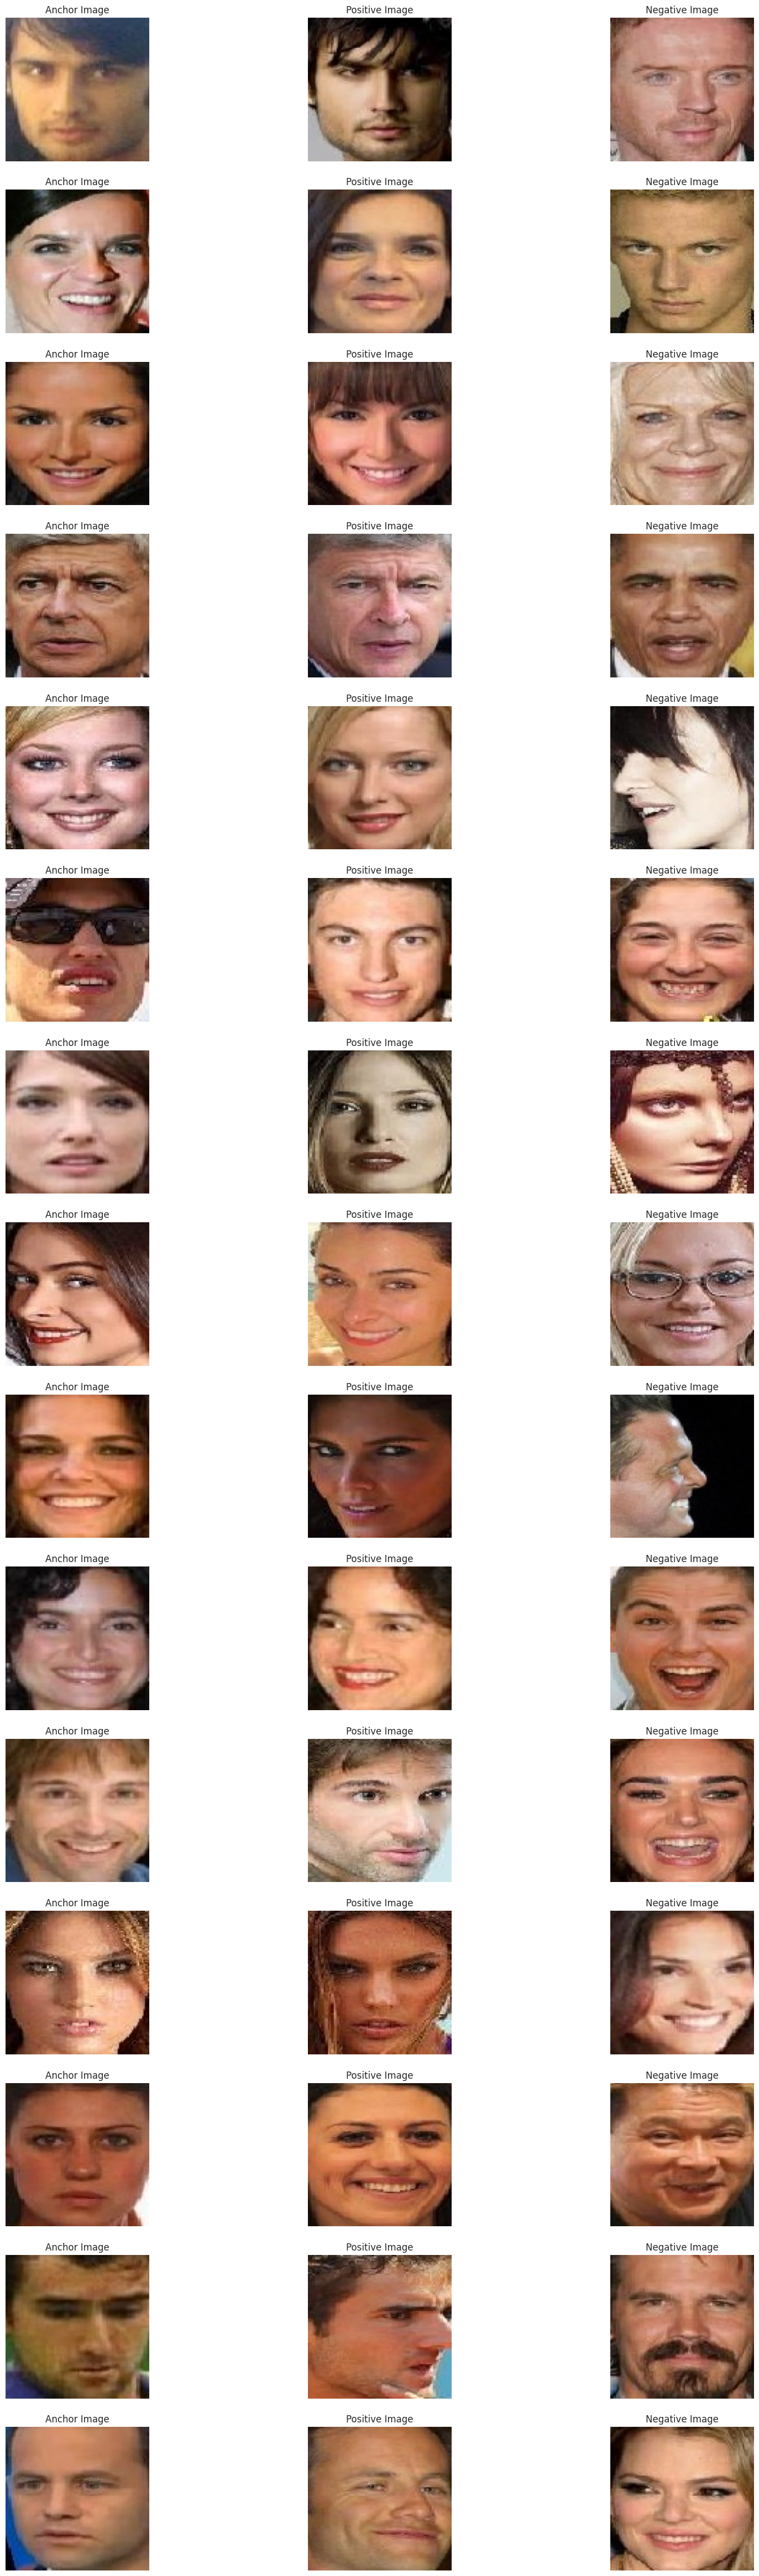

In [15]:
samples = train_generator[0]

f, axarr = plt.subplots(15,3,figsize=(20, 60))

for i in range(0,15):

    axarr[i,0].imshow(samples[0][i])
    axarr[i,0].title.set_text('Anchor Image')
    axarr[i,0].axis('off')
    axarr[i,1].imshow(samples[1][i])
    axarr[i,1].title.set_text('Positive Image')
    axarr[i,1].axis('off')
    axarr[i,2].imshow(samples[2][i])
    axarr[i,2].title.set_text('Negative Image')
    axarr[i,2].axis('off')

In [16]:
checkpoint = ModelCheckpoint("model.keras",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1,)
                            #  save_weights_only=True)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=4,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.00000001)

# Model Subclass

In [17]:
class SiameseModel(Model):

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name='loss')

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss,self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(
                    zip(gradients,self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        anchor, positive, negative = self.siamese_network(data)
        # Access the first element of each list to get the tensors
        anchor = anchor[0]
        positive = positive[0]
        negative = negative[0]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), -1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), -1)
        loss = pos_dist - neg_dist + self.margin
        loss = tf.maximum(loss, 0.0)
        return loss

    # def _compute_loss(self, data):
    #     anchor, positive, negative = self.siamese_network(data)
    #     pos_dist = tf.reduce_sum(tf.square(anchor-positive), -1)
    #     neg_dist = tf.reduce_sum(tf.square(anchor-negative), -1)
    #     loss = pos_dist - neg_dist + self.margin
    #     loss = tf.maximum(loss, 0.0)
    #     return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

In [18]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

# Training Model

In [19]:
try:
    history = siamese_model.fit(train_generator, validation_data=test_generator,
                            epochs=50,callbacks=[checkpoint,earlystop]) #,learning_rate_reduction
except KeyboardInterrupt:
    print("\nTraining Stopped!")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(None, 100, 100, 3))
  warnings.warn(msg)


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - loss: 0.4590
Epoch 1: val_loss improved from inf to 0.38292, saving model to model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


448/448 ━━━━━━━━━━━━━━━━━━━━ 281s 607ms/step - loss: 0.4589 - val_loss: 0.3829
Epoch 2/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - loss: 0.3697
Epoch 2: val_loss improved from 0.38292 to 0.32727, saving model to model.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 271s 604ms/step - loss: 0.3696 - val_loss: 0.3273
Epoch 3/50
 19/448 ━━━━━━━━━━━━━━━━━━━━ 4:05 572ms/step - loss: 0.2979
Training Stopped!


In [20]:
siamese_model.save('/content/drive/MyDrive/Project/Face-Recognition/face_recognition.h5')
siamese_model.save('/content/drive/MyDrive/Project/Face-Recognition/face_recognition.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [33]:
siamese_network.load_weights("/content/drive/MyDrive/Project/Face-Recognition/face_recognition.h5")

In [26]:
test_generator1

In [33]:
test_generator

In [35]:
y_pred = siamese_model.predict(test_generator)

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(None, 100, 100, 3))
  warnings.warn(msg)


63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step


# Inference

In [31]:
test.head()

anchor   id1         pos   id2         neg   id3
14332  117844.jpg  7653  123956.jpg  7653  042087.jpg  3628
14333  030449.jpg  9642  133860.jpg  9642  067238.jpg  1217
14334  119921.jpg  5347  136694.jpg  5347  057987.jpg  2532
14335  070842.jpg  8877  025723.jpg  8877  000236.jpg  2292
14336  119098.jpg  9716  077325.jpg  9716  052916.jpg  2718

In [66]:
len(test)

2000

In [69]:
len(y_pred[1][0])

2000

In [56]:
from sklearn.metrics.pairwise import euclidean_distances as L2, cosine_similarity as cs

distances = []
for i in range(len(y_pred[2])):
    pos_dist = L2(y_pred[0][i].reshape(1, -1), y_pred[1][i].reshape(1, -1))[0][0]
    neg_dist = L2(y_pred[0][i].reshape(1, -1), y_pred[2][i].reshape(1, -1))[0][0]
    distances.append([pos_dist, neg_dist])
distances

[[26.607315, 36.077522]]

In [ ]:
distances = []
for i in range(len(test)):
    pos = L2(y_pred[0][i,:].reshape(1,-1),y_pred[1][i,:].reshape(1,-1))[0][0]
    neg = L2(y_pred[0][i,:].reshape(1,-1),y_pred[2][i,:].reshape(1,-1))[0][0]
    distances.append([pos,neg])

In [ ]:
test.loc[:,['pos_dist','neg_dist']] = distances
test.head()

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(x="value", y="variable", data=pd.melt(test[['pos_dist','neg_dist']]))
plt.rc('font', size=20)
plt.show()

In [ ]:
len(test[(test['pos_dist']<30) & (test['neg_dist']>30)])/len(test)

# Extract Embeddings

In [57]:
siamese_network.layers

[<InputLayer name=Image1, built=True>,
 <InputLayer name=Image2, built=True>,
 <InputLayer name=Image3, built=True>,
 <Functional name=embedding, built=True>]

In [58]:
face_embeddings = siamese_network.layers[-1]

# Pipeline Face Recognition

## Face Detection

In [ ]:
haar_file = '/content/haarcascade_frontalface_default.xml'
face_cascade=cv2.CascadeClassifier(haar_file)

def haar_face(image):
  img = cv2.imread(image)
  img = cv2.resize(img,(1000,1000))
  faces=face_cascade.detectMultiScale(img,1.1,5)
  for (p,q,r,s) in faces:
    face = img[q:q+s,p:p+r]
  face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
  face = cv2.resize(face, (100, 100))
  return face

def haar_face(image):
  img = cv2.imread(image)
  img = cv2.resize(img,(1000,1000))
  faces=face_cascade.detectMultiScale(img,1.1,5)
  for (p,q,r,s) in faces:
    face = img[q:q+s,p:p+r]
    x = p
    y = q
    w = r
    h = s
  return faces

alreza = haar_face('/content/IMG_001.JPG')
alreza2 = haar_face('/content/IMG_002.JPG')
mygirl = haar_face('/content/IMG_003.JPG')

## Get Embedding dan Hitung Euclidean Dist

In [ ]:
emb1 = face_embeddings.predict(np.expand_dims(alreza,axis=0))
emb2 = face_embeddings.predict(np.expand_dims(alreza,axis=0))
emb3 = face_embeddings.predict(np.expand_dims(mygirl,axis=0))

print(L2(emb1,emb2))
print(L2(emb1,emb3))

In [77]:
face_embeddings.save('/content/drive/MyDrive/Project/Face-Recognition/face_embeddings.h5')
face_embeddings.save('/content/drive/MyDrive/Project/Face-Recognition/face_embeddings.keras')

# Implmentasi

In [ ]:
data = os.listdir('/content/myimage/myimage')

label = map(lambda x: x.split('.')[0], data)
label = list(label)

faces = []
for image in data:
  img = haar_face('/content/myimage/myimage/'+image)
  faces.append(img)

faces = np.array(faces)
embeddings = face_embeddings.predict(faces)
embeddings.shape

In [ ]:
def query_face(directory, filename, embeddings, label, thresh):

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 2
    color = (255, 255, 255)
    thickness = 4

    # 1
    query_img = read_image(directory,filename)
    query_img = np.expand_dims(query_img,axis=0)
    #2
    query_embedding = face_embeddings.predict(query_img)
    #3
    distances = L2(embeddings, query_embedding)

    #4
    index = np.argmin(distances,axis=0)
    q_index = index[0] if distances[index] < thresh else None
    label = 'Unknown'
    try:
        label = label[q_index]
    except TypeError:
        pass

    #5
    (width, height),b = cv2.getTextSize(label, font, fontScale, thickness)

    img = cv2.imread(os.path.join(directory,filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x,y,w,h = haar_fase_cut(img)

    img = cv2.rectangle(img, (x, y), (x+w, y+h), (51, 153, 255), 5)
    img = cv2.rectangle(img, (x, y-height), (x+width, y), (51, 153, 255), -1)
    img = cv2.putText(img, label, (x,y), font,
                       fontScale, color, thickness, cv2.LINE_AA)

    return img

In [ ]:
query_images = os.listdir('/content/database')
plt.figure(figsize = (20 , 20))
n = 0
for image in query_images:
    n+=1
    plt.subplot(2 , 5, n)
    img = query_face(directory,image,db_embeddings,db_names,1.65)
    plt.imshow(img)
    plt.axis("off")